# Example case for causal inference in ecommerce pricing
## Data Prep Notebook
Lars Roemheld, 2021. http://mdl.fit/

This prep script cleans a public dataset and prepares it for further use.

The notebook originally accompanies a workshop on causal inference for Machine Learners. Reach out if you are interested to learn more.

In [1]:
import pandas as pd, numpy as np
from datetime import datetime, date
from matplotlib import pyplot as plt
import seaborn as sns

# Sample ecommerce dataset 
For this example, I'll use a public domain (CC0 1.0 Universal) dataset, sourced from https://www.kaggle.com/vijayuv/onlineretail . Judging from artifacts in the data, this is likely original data from Dotcomgiftshop (a real FBA reseller, now also branding under https://www.rexlondon.com/ ).

**NB: This data has one _significant_ technical limitation: we only observe sales, not stock-days. That means we have no data at all about prices on days where 0 sales occured. Since typically a majority of stock units are rarely sold, this is a big issue - but one we're choosing to ignore for this example.** Note that because we have no information about stock-outs and product introductions, we can *not* assume 0 sales for "missing" product-date-combinations - and worse, if we did, we wouldn't have any valid information on price.

Throughout this notebook, we sometimes use `SKU` to mean stock-keeping-unit, i.e. `StockCode` in this dataset or "item"/"product".

In [2]:
df = pd.read_csv('data/OnlineRetail_utf8.csv')
len(df)

541909

In [3]:
df.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
473691,576837,22361,GLASS JAR DAISY FRESH COTTON WOOL,4,11/16/2011 15:16,5.79,NaN,United Kingdom
123900,546922,47566,PARTY BUNTING,4,3/18/2011 9:59,4.95,14110.0,United Kingdom
128156,547250,21773,DECORATIVE ROSE BATHROOM BOTTLE,2,3/22/2011 9:30,2.46,NaN,United Kingdom
329785,565854,21914,BLUE HARMONICA IN BOX,12,9/7/2011 13:22,1.25,12490.0,France
466637,576329,21935,SUKI SHOULDER BAG,7,11/14/2011 15:22,1.63,NaN,United Kingdom
77052,542691,22421,LIPSTICK PEN FUSCHIA,36,1/31/2011 12:34,0.42,13408.0,United Kingdom
192586,553461,16161P,WRAP ENGLISH ROSE,25,5/17/2011 10:57,0.42,16316.0,United Kingdom
441559,574587,48194,DOORMAT HEARTS,2,11/6/2011 10:29,8.25,14936.0,Channel Islands
529416,580730,84032A,CHARLIE+LOLA PINK HOT WATER BOTTLE,4,12/5/2011 17:28,3.29,NaN,United Kingdom
380838,569841,23536,VILLAGE SHOW WALL ART,4,10/6/2011 13:27,5.95,17428.0,United Kingdom


## ad-hoc data cleaning
df contains returns and "stock adjustments", which have funky customer service return comments in "description"

In [4]:
df[df.Description=='OOPS ! adjustment']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
345011,567132,21830,OOPS ! adjustment,-384,9/16/2011 14:14,0.0,NaN,United Kingdom


In [5]:
df = df[
    (df.Quantity > 0) &
    (df.UnitPrice > 0)
]

In [6]:
df.groupby('StockCode').Description.nunique().sort_values(ascending=False)

StockCode
23236     4
23196     4
17107D    3
22776     3
23366     3
         ..
46776B    1
46776A    1
46775D    1
46138B    1
10002     1
Name: Description, Length: 3922, dtype: int64

Ok, now we still have some funkyness, but it's looking plausible now.

In [7]:
df[df.StockCode=='17107D'].Description.drop_duplicates()

6467      FLOWER FAIRY,5 SUMMER B'DRAW LINERS
315743           FLOWER FAIRY 5 DRAWER LINERS
347764      FLOWER FAIRY 5 SUMMER DRAW LINERS
Name: Description, dtype: object

There are some more manual interactions:
```
POST          244.582494
DOT           355.726548
M             649.568766
AMAZONFEE    9419.772483
etc
```

In [8]:
df = df[~df.StockCode.isin(['POST', 'DOT', 'M', 'AMAZONFEE', 'BANK CHARGES', 'C2', 'S'])]

In [9]:
len(df)

527794

## Quick visualization for plausibility checks

In [10]:
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate)
df['Date'] = pd.to_datetime(df.InvoiceDate.dt.date)
df['revenue'] = df.Quantity * df.UnitPrice

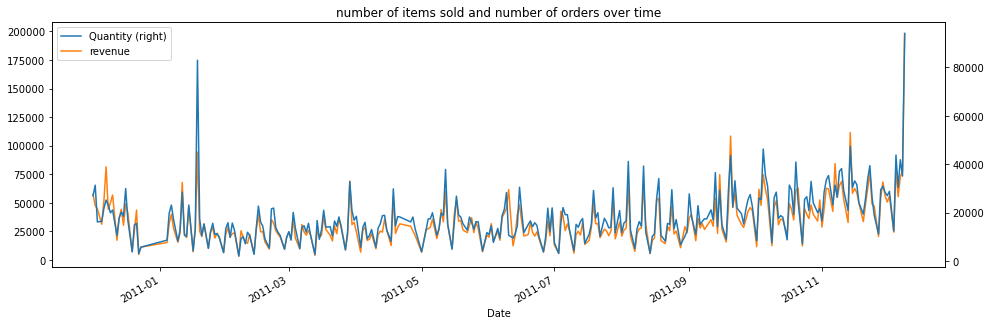

In [11]:
df.groupby('Date').agg(
    {'Quantity': 'sum', 'revenue': 'sum'}
).plot(
    title='number of items sold and number of orders over time', 
    secondary_y='Quantity',
    figsize=(16, 5)
)

Shop seems to have been closed for christmas 2010...

And we see some crazy outliers in quantity - let's check them out.

In [12]:
df.nlargest(5, columns='Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,revenue
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,2011-12-09,168469.60
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,77183.60
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom,2011-10-27,1008.00
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135.0,United Kingdom,2011-05-27,3096.00
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087.0,United Kingdom,2011-02-22,3202.92


Odd - those super large orders may or may not be real. Verified that the customers only ever had that one order. Let's censor them.

In [13]:
df = df[~df.CustomerID.isin([16446.0, 12346.0])]

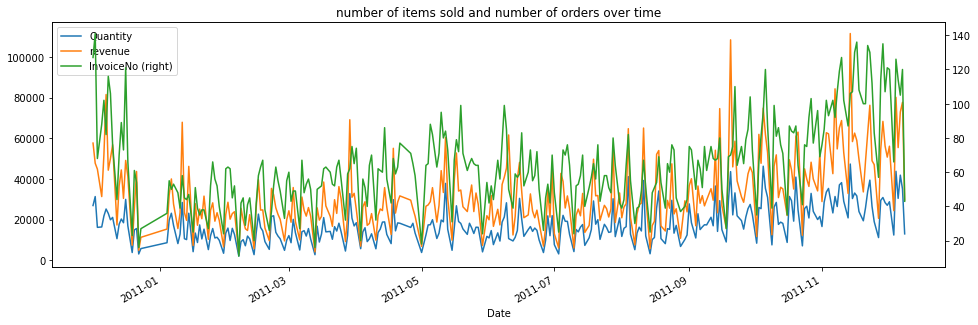

In [14]:
df.groupby('Date').agg(
    {'Quantity': 'sum', 'revenue': 'sum', 'InvoiceNo': 'nunique'}
).plot(
    title='number of items sold and number of orders over time', 
    secondary_y='InvoiceNo',
    figsize=(16, 5)
)

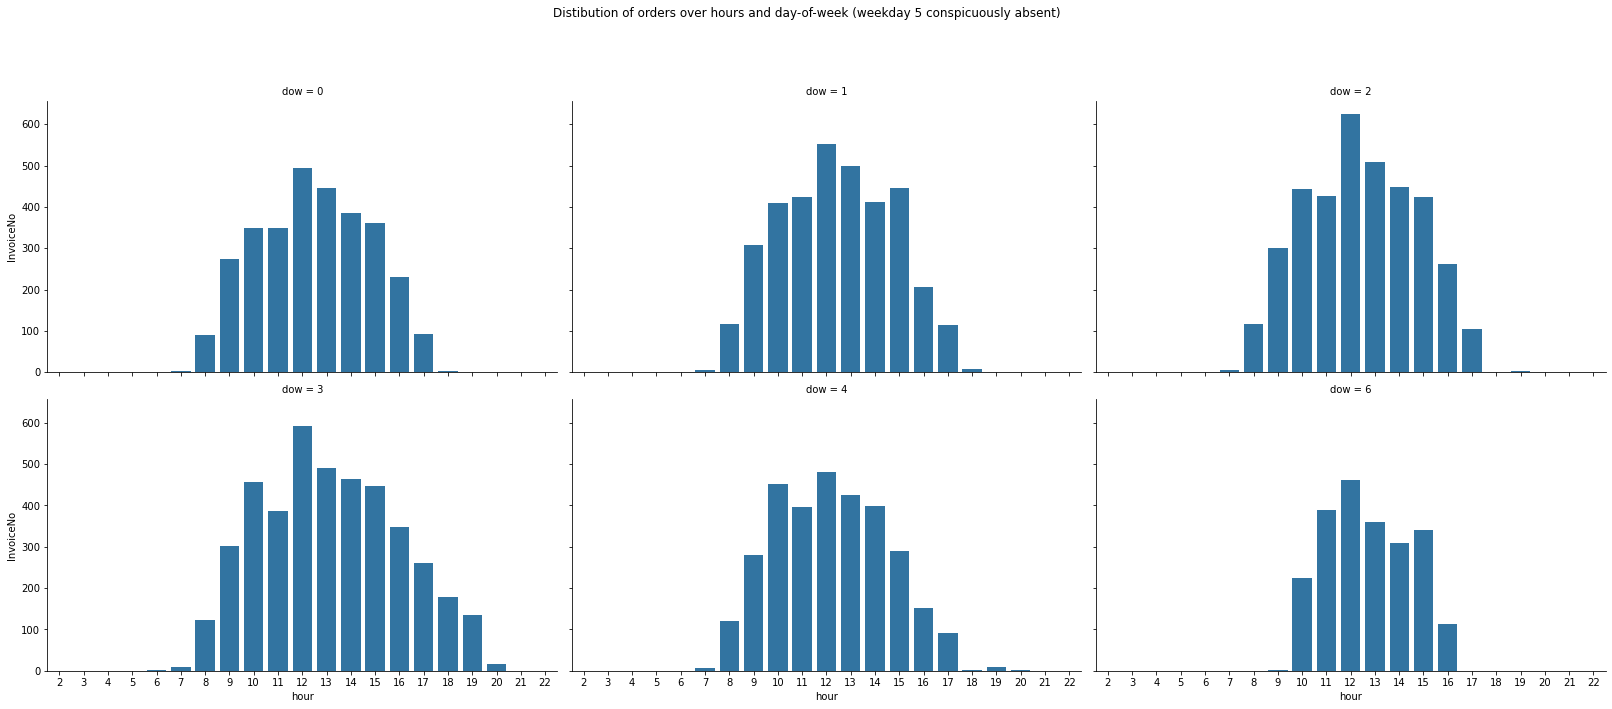

In [15]:
sns.FacetGrid(
    data=df.assign(
        hour=df.InvoiceDate.dt.hour,
        dow=df.InvoiceDate.dt.weekday,
    ).groupby(['dow', 'hour'], as_index=False).agg({'InvoiceNo': 'nunique'}),
    col='dow', col_wrap=3,
    height=5, aspect=1.5, 
).map(
    sns.barplot, 'hour', 'InvoiceNo', order=[h for h in range(2, 23)]
)
plt.suptitle('Distibution of orders over hours and day-of-week (weekday 5 conspicuously absent)')
plt.subplots_adjust(top=0.85)

## Final transformation
To simplify the problem & speed up algos, we summarize the data to the relevant unit of observation: item (SKU) x date x country level (summing over individual orders, discarding "hour" information).

Before we do that, for some opinionated data cleaning, we'll do the following
- censor observations with implausibly large price deviation - a few products have sales for 100x their normal price. That seems more likely to be a data error than anything else. If not removed, those outliers mess with later analysis

In [16]:
len(df)

527790

In [17]:
df = (
    df
    .assign(
        dNormalPrice=lambda d: d.UnitPrice 
            / d.groupby('StockCode').UnitPrice.transform('median') 
    )
    .pipe(
        lambda d: d[
            (d['dNormalPrice'] > 1./3) &
            (d['dNormalPrice'] < 3.)
        ]
    )
    .drop(columns=['dNormalPrice'])
)

In [18]:
len(df)

518418

In [19]:
df = df.groupby(['Date', 'StockCode', 'Country'], as_index=False).agg({
    'Description': 'first',
    'Quantity': 'sum', 
    'revenue': 'sum'
})
df['Description'] = df.groupby('StockCode').Description.transform('first')

df['UnitPrice'] = df['revenue'] / df['Quantity'] # implicit quantity-weighted avg of prices

In [20]:
len(df)

298222

In [21]:
df.to_parquet('ecom_sample_clean.parquet')